# Titanic with Pandas and Scikit-Learn

* **Survived**: Survival (0 = no; 1 = yes)
* **Pclass**: Passenger class (1 = first; 2 = second; 3 = third) ---- *categorical variable*
* **Name**
* **Sex** ---- *categorical variable*
* **Age**
* **SibSp**: Number of siblings aboard
* **Parch**: Number of parents/children aboard
* **Ticket**: Ticket number
* **Fare**: Passenger fare
* **Cabin**
* **Embarked**: Port of embarkation (C = Cherbourg; Q = Queenstown; S = Southampton) ---- *categorical variable*

## Data Exploration

First, import some useful modules

In [1]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # use seaborn, see https://stanford.edu/~mwaskom/software/seaborn/
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from collections import Counter

Load the training data set into a pandas data frame and see how many records are there and what is in the data

In [2]:
training_df = pd.read_csv("train.csv")
training_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [103]:
testing_df = pd.read_csv("test.csv")
testing_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Missing Values in the Training Dataset

In [4]:
nrows = len(training_df.index)
print("there are {} rows in training database".format(nrows))
training_df.count()-nrows  # this returns the number of missing observations in each column

there are 891 rows in training database


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age           -177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin         -687
Embarked        -2
dtype: int64

In [104]:
nrows = len(testing_df.index)
print("there are {} rows in testing database".format(nrows))
testing_df.count()-nrows  # this returns the number of missing observations in each column

there are 418 rows in testing database


PassengerId      0
Pclass           0
Name             0
Sex              0
Age            -86
SibSp            0
Parch            0
Ticket           0
Fare            -1
Cabin         -327
Embarked         0
dtype: int64

**Note**: since there are too many missing values in Cabin, we will ignore this variable.
Also, it doesn't seem possible to reliably estimate the two missing Embarked values; as it's only two values, we will ignore both rows where Embarked is not available. 
The key question here is how to estimate Age.

In [116]:
def preprocess_data(df):
    
    # estimate age from title
    
    same_as_mrs = ["Mrs","Mme","the Countess","Lady","Dona"]
    same_as_mr = ["Capt","Col","Don","Mr","Jonkheer","Major","Rev","Sir","Dr"]
    same_as_ms = ["Ms","Miss","Mlle"]
    
    tmp_df = df.copy()  # deep copy
    
    # create feature Title
    tmp_df["Title"]= df["Name"].apply(lambda _: _.split(",")[1].split(".")[0].strip()).astype(str)
    
    aver_age_miss = round(tmp_df[~tmp_df["Age"].isnull()  & (tmp_df["Title"].str.strip().isin(same_as_ms))]["Age"].mean(),1)
    aver_age_mrs = round(tmp_df[~tmp_df["Age"].isnull()  & (tmp_df["Title"].str.strip().isin(same_as_mrs))]["Age"].mean(),1)
    aver_age_mr = round(tmp_df[~tmp_df["Age"].isnull()  & (tmp_df["Title"].str.strip().isin(same_as_mr))]["Age"].mean(),1)
    
    if np.sum(tmp_df["Title"].str.strip().isin(["Master"])) > 0:
        
        aver_age_master = round(tmp_df[~tmp_df["Age"].isnull()  & (tmp_df["Title"].str.strip().isin(["Master"]))]["Age"].mean(),1)
        master_idx = tmp_df["Title"].str.strip().isin(["Master"])
        tmp_df.loc[master_idx, "Age"] = tmp_df.loc[master_idx, "Age"].fillna(aver_age_master)
    
    miss_idx = tmp_df["Title"].str.strip().isin(same_as_ms)
    mr_idx = tmp_df["Title"].str.strip().isin(same_as_mr)
    mrs_idx = tmp_df["Title"].str.strip().isin(same_as_mrs)
    
    tmp_df.loc[miss_idx, "Age"] = tmp_df.loc[miss_idx, "Age"].fillna(aver_age_miss)
    tmp_df.loc[mr_idx,"Age"] = tmp_df.loc[mr_idx,"Age"].fillna(aver_age_mr)
    tmp_df.loc[mrs_idx,"Age"] = tmp_df.loc[mrs_idx,"Age"].fillna(aver_age_mrs)
    
    tmp_df = tmp_df.drop(["Title","Cabin","PassengerId","Name","Ticket"],axis=1)
    
    # if Fare is absent, estimate as the mean fare
    nofare_idx = tmp_df["Fare"].isnull()
    mean_fare = round(tmp_df.loc[~nofare_idx]["Fare"].mean(),2)
    print("estimating the missing fare as the mean fare {}".format(mean_fare))
    
    tmp_df.loc[nofare_idx,"Fare"] = tmp_df.loc[nofare_idx,"Fare"].fillna(mean_fare)
    
    # ignore rows with absent Embarked
    tmp_df = tmp_df.drop(tmp_df.index[tmp_df["Embarked"].isnull()])
    
    # normalize Age, SibSp,Parch and Fare
    from sklearn.preprocessing import StandardScaler
    stdsc = StandardScaler()
    tmp_df[["Age","SibSp","Parch","Fare"]] = stdsc.fit_transform(tmp_df[["Age","SibSp","Parch","Fare"]])
    
    # encode categorical features "Sex" and "Embarked" into integers:
    le_sex = LabelEncoder()
    tmp_df["Sex_Int"] = le_sex.fit_transform(tmp_df["Sex"])
    le_emb = LabelEncoder()
    tmp_df["Emb_Int"] = le_emb.fit_transform(tmp_df["Embarked"])
    # drop Sex and Embarked to avoid problems with OHE
    tmp_df = tmp_df.drop(["Sex","Embarked"],1)
    
    print(tmp_df.head())
    
    tmp_df = tmp_df.join(pd.get_dummies(tmp_df["Pclass"],prefix="pcl"))
    tmp_df = tmp_df.join(pd.get_dummies(tmp_df["Sex_Int"],prefix="sex"))
    # tmp_df = tmp_df.join(pd.get_dummies(tmp_df["Emb_Int"],prefix="emb"))
    
    tmp_df = tmp_df.drop(["Sex_Int","Emb_Int","Pclass"],1)
    
    return tmp_df

In [117]:
training_processed = preprocess_data(training_df)
print("processed training dataset has {} rows".format(len(training_processed.index)))
training_processed.head()


estimating the missing fare as the mean fare 32.2
   Survived  Pclass       Age     SibSp     Parch      Fare  Sex_Int  Emb_Int
0         0       3 -0.587549  0.431350 -0.474326 -0.500240        1        2
1         1       1  0.620036  0.431350 -0.474326  0.788947        0        0
2         1       3 -0.285653 -0.475199 -0.474326 -0.486650        0        2
3         1       1  0.393614  0.431350 -0.474326  0.422861        0        2
4         0       3  0.393614 -0.475199 -0.474326 -0.484133        1        2
processed training dataset has 889 rows


,Survived,Age,SibSp,Parch,Fare,pcl_1,pcl_2,pcl_3,sex_0,sex_1
0,0,-0.587549,0.431350,-0.474326,-0.500240,0,0,1,0,1
1,1,0.620036,0.431350,-0.474326,0.788947,1,0,0,1,0
2,1,-0.285653,-0.475199,-0.474326,-0.486650,0,0,1,1,0
3,1,0.393614,0.431350,-0.474326,0.422861,1,0,0,1,0
4,0,0.393614,-0.475199,-0.474326,-0.484133,0,0,1,0,1


### A few plots to see what's going on

<IPython.core.display.Javascript object>


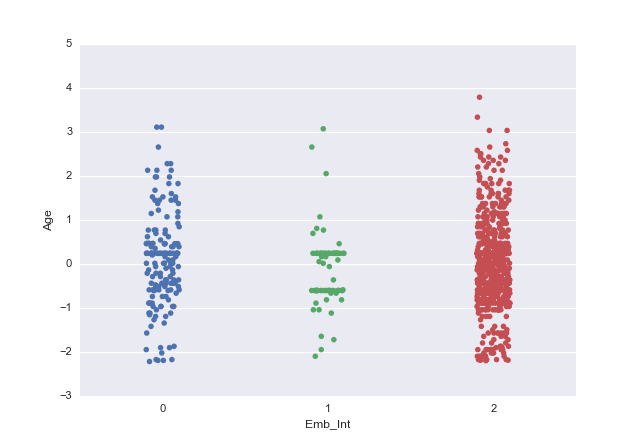

In [49]:
plt.figure()
sns.stripplot(x="Emb_Int", y="Age", data=training_processed, jitter=True);

So, what's interesting about this? 
* There was only a few people over 60 on Titanic
* Not many children either
* Not many people embarked in Queenstown

<IPython.core.display.Javascript object>


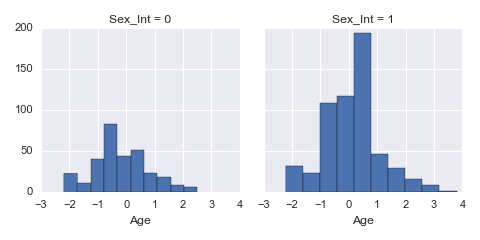

In [51]:
sns.FacetGrid(training_processed, col="Sex_Int").map(plt.hist, "Age")

Apparently, more males than females on board. Males were typically aged 20 to 40.

<IPython.core.display.Javascript object>


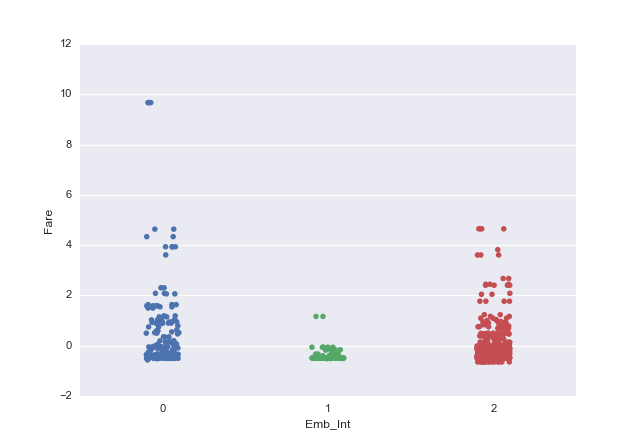

In [52]:
plt.figure()
sns.stripplot(x="Emb_Int", y="Fare",data=training_processed, jitter=True);

We see that passengers that embarked in Queenstown bought the cheapest tickets except for 2 persons who paid nearly 100 pounds each.

What to do about the missing values? Let's check how manuy of these we've got.

All looks good except **Age**. And there are 2 values missing in **Embarked**. It's not obvious what we should do with **Embarked** and if it's important at all. However, we do need to deal with **Age**. We could just set all absent age values to 0 or ignore all records where age is not available. Or, we could approximate the age based on Title. How often do we see records with no age but some title present?

In [10]:
len(tdf[tdf["Age"].isnull() & tdf["Title"].notnull()].index)

177

## Prediction

Split training data into the training and testing datasets. We will not be using **Title** and **Deck** for prediction.

In [118]:
X = training_processed.iloc[:,1:]  # variables
y = training_processed.iloc[:,0]   # outcome

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

X_train.head()

,Age,SibSp,Parch,Fare,pcl_1,pcl_2,pcl_3,sex_0,sex_1
485,-0.602644,2.244449,0.765897,-0.133482,0,0,1,1,0
334,0.461541,0.431350,-0.474326,2.044579,1,0,0,1,0
773,0.242666,-0.475199,-0.474326,-0.500743,0,0,1,0,1
383,0.393614,0.431350,-0.474326,0.400715,1,0,0,1,0
332,0.620036,-0.475199,0.765897,2.443465,1,0,0,0,1


### Logictic Regression

In [119]:
lr_parameters = {'penalty':['l2','l1'],'C':np.arange(0.1,1.0,0.1).tolist()}
lr = LogisticRegression()
lrc = GridSearchCV(lr, lr_parameters)
lrc.fit(X_train, y_train)
print('Training accuracy:', lrc.score(X_train, y_train))
print('Testing accuracy:', lrc.score(X_test, y_test))

Training accuracy: 0.794655414909
Testing accuracy: 0.837078651685


### Decision Tree

In [121]:
dt_parameters = {'min_samples_leaf': np.arange(0.025,0.5,0.025).tolist()}
clf = tree.DecisionTreeClassifier(splitter="random")
dtc = GridSearchCV(clf, dt_parameters)
dtc.fit(X_train, y_train)
print(accuracy_score(y_test, dtc.predict(X_test)))

0.887640449438


### Naive Bayes

In [122]:
nbc = GaussianNB()
nbc.fit(X_train, y_train)
print(accuracy_score(y_test, nbc.predict(X_test)))

0.814606741573


### RandomForests

In [123]:
rf_parameters = {'n_estimators': np.arange(1,100,1).tolist(),'min_weight_fraction_leaf':np.arange(0.025,0.5,0.025).tolist()}
rf = RandomForestClassifier(max_features='sqrt')
rfc = GridSearchCV(rf, rf_parameters)
rfc.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, ...000000003, 0.37500000000000006, 0.4, 0.42500000000000004, 0.45000000000000007, 0.47500000000000003]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [124]:
print(accuracy_score(y_test, rfc.predict(X_test)))
print(rfc.best_params_)

0.842696629213
{'n_estimators': 10, 'min_weight_fraction_leaf': 0.025}


In [125]:
best_rf = rfc.best_estimator_
best_rf.fit(X_train, y_train)
print(accuracy_score(y_test, best_rf.predict(X_test)))
print(best_rf.feature_importances_)

0.831460674157
[ 0.04482091  0.02449779  0.02668686  0.19775484  0.03243535  0.00984649
  0.10979981  0.26210514  0.29205281]


## Extra Trees

In [126]:
xt_parameters = {"n_estimators":np.arange(1,50,1).tolist(), "min_samples_split":np.arange(1,20,1).tolist() }
xt = ExtraTreesClassifier(max_depth=None, random_state=0)
xtc = GridSearchCV(xt, xt_parameters)
xtc.fit(X_train, y_train)
print(accuracy_score(y_test, xtc.predict(X_test)))

0.859550561798


In [127]:
xtc.best_estimator_

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=7, min_weight_fraction_leaf=0.0,
           n_estimators=21, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [132]:
testing_df_processed = preprocess_data(testing_df)
Y_pred = dtc.predict(testing_df_processed)  # note we use the RandomForests model here
print("predicted {} survival outcomes".format(len(Y_pred)))

estimating the missing fare as the mean fare 35.63
   Pclass       Age     SibSp     Parch      Fare  Sex_Int  Emb_Int
0       3  0.328100 -0.499470 -0.400248 -0.498407        1        1
1       3  1.289151  0.616992 -0.400248 -0.513274        0        2
2       2  2.442413 -0.499470 -0.400248 -0.465089        1        1
3       3 -0.248531 -0.499470 -0.400248 -0.483466        1        2
4       3 -0.632951  0.616992  0.619896 -0.418472        0        2
predicted 418 survival outcomes


Format precistions for submission. Recall that we have to submit a .csv with 2 columns, PassengerID and Survived.

In [133]:
submission_df = pd.DataFrame(columns=["PassengerId","Survived"])
submission_df["PassengerId"] = testing_df["PassengerId"]
submission_df["Survived"] = Y_pred
submission_df.head()

# save this data frame to a .csv file
submission_df.to_csv("titanic_submission.csv",index=False)

This looks right. Next step - submit :)